In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr


%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time


plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

In [2]:
ml = {'RW_ECO4' : {'desc' : 'RW_ECO4 (ERA5)',
                         'start': 0,
                         'end' : 0,
                       'color' : 'red',
                         'linestyle' : '-',
                      },
      'RW_GCBa' : {'desc' : 'RW_GCBa (ERA5)',
                         'start': 0,
                         'end' : 0,
                       'color' : 'navy',
                         'linestyle' : '-',
                      },
      'RW_CO2a' : {'desc' : 'RW_CO2a (ERA5)',
                         'start': 0,
                         'end' : 0,
                       'color' : 'gold',
                         'linestyle' : '-',
                      },
    'TJ_RVA0' : {'desc' : 'TJ_RVA0 \n (GCB23, ERA5)',
                     'start': 0,
                     'end' : 0,
                   'color' : 'grey',
                     'linestyle' : '-',
                  },
      
      'TJ_EA01' : {'desc' : 'TJ_EA01 \n (ECO, UKESM)',
                 'start': 0,
                 'end' : 0,
               'color' : 'red',
                 'linestyle' : ':',
              },
      
        'TJ_GA01' : {'desc' : 'TJ_GA01 \n (GCB, UKESM)',
             'start': 0,
             'end' : 0,
           'color' : 'navy',
             'linestyle' : ':',
          },
      
        'TJ_CA01' : {'desc' : 'TJ_CA01 \n (CO2, UKESM)',
             'start': 0,
             'end' : 0,
           'color' : 'gold',
             'linestyle' : ':',
          },    

          }


In [3]:
def get_sev(mn):
    

    '''get start year, end yer, check for diadv in a model'''
    
    tstart = -999
    tend = -999   
    
    tc = f'/gpfs/data/greenocean/software/runs/TOM12_{mn}/ORCA2_1m_*grid_V*'
    w = (glob.glob(tc))
    w2 = sorted(w)

    if len(w2) == 0:
        
        return tstart, tend
    
    else:
        
        sa = w2[0]
        en = w2[-1]
        
        parts = sa.split('ORCA2_1m_')
        tstart = int(parts[1][0:4])
        parts = en.split('ORCA2_1m_')
        tend = int(parts[1][0:4])
        
        
        
    return tstart, tend
    
for m in ml:
    
    print(m)
    tstart, tend = get_sev(m)
    ml[m]['start'] = tstart
    ml[m]['end'] = tend


RW_ECO4
RW_GCBa
RW_CO2a
TJ_RVA0
TJ_EA01
TJ_GA01
TJ_CA01


In [4]:
print(ml)

{'RW_ECO4': {'desc': 'RW_ECO4 (ERA5)', 'start': 1920, 'end': 2022, 'color': 'red', 'linestyle': '-'}, 'RW_GCBa': {'desc': 'RW_GCBa (ERA5)', 'start': 1948, 'end': 1995, 'color': 'navy', 'linestyle': '-'}, 'RW_CO2a': {'desc': 'RW_CO2a (ERA5)', 'start': 1920, 'end': 2022, 'color': 'gold', 'linestyle': '-'}, 'TJ_RVA0': {'desc': 'TJ_RVA0 \n (GCB23, ERA5)', 'start': 1940, 'end': 2022, 'color': 'grey', 'linestyle': '-'}, 'TJ_EA01': {'desc': 'TJ_EA01 \n (ECO, UKESM)', 'start': 1940, 'end': 2100, 'color': 'red', 'linestyle': ':'}, 'TJ_GA01': {'desc': 'TJ_GA01 \n (GCB, UKESM)', 'start': -999, 'end': -999, 'color': 'navy', 'linestyle': ':'}, 'TJ_CA01': {'desc': 'TJ_CA01 \n (CO2, UKESM)', 'start': 1940, 'end': 2100, 'color': 'gold', 'linestyle': ':'}}


Text(0.5, 0.98, 'ocean regions, subdivided, with atlantic mask')

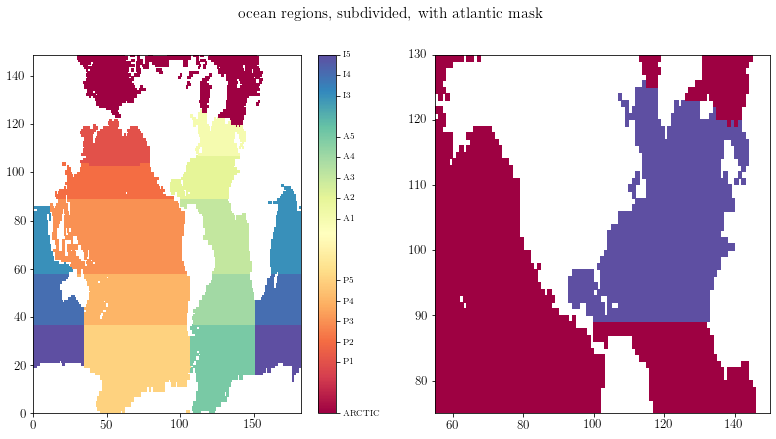

In [94]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

masknoATL = np.copy(maskno)

masknoATL[np.where(masknoATL == 2.6) ]= 5
masknoATL[np.where(masknoATL == 2.4) ]= 5
masknoATL[masknoATL < 5] = 0

fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics, ax = axs[0])
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

w = axs[1].pcolor(masknoATL, cmap = tcm, vmin = 0.5, vmax = 4)
axs[1].set_xlim([55,150])
axs[1].set_ylim([75,130])
plt.suptitle('ocean regions, subdivided, with atlantic mask')

In [95]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def get_ts(yrst = 1959, yrend = 2022, var = 'Cflx', ttype = 'diad_T', trun = 'TOM12_TJ_RVA0',\
    
           
    madein = '/AMOC-PLANKTOM/available-model-survey.ipynb',\
    tunits = ''):

    savenam = f'./data/NAtl_{var}_{trun}_{yrst}-{yrend}.nc'
    print(savenam)
    ### make atlantic mask
    regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

    regdict = {'ARCTIC' : {'number' : 0.5},
               'P1' : {'number': 1.0},
              'P2' : {'number': 1.2},
               'P3' : {'number': 1.4},
               'P4' : {'number': 1.6},
               'P5' : {'number': 1.8},
                'A1' : {'number': 2.4},
              'A2' : {'number': 2.6},
               'A3' : {'number': 2.8},
               'A4' : {'number': 3},
               'A5' : {'number': 3.2},
               'I3' : {'number': 3.6},
               'I4' : {'number': 3.8},
               'I5' : {'number': 4},

              }
    
    
    tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')
    maskno = np.zeros([149,182])
    for i in range(0, len(regs)):
        maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
        tics.append(regdict[regs[i]]['number'])
    maskno[maskno == 0] = np.nan

    masknoATL = np.copy(maskno)

    masknoATL[np.where(masknoATL == 2.6) ]= 5
    masknoATL[np.where(masknoATL == 2.4) ]= 5
    masknoATL[masknoATL < 5] = 0
    
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    tmesh['csize'] = tmesh['csize'].where(masknoATL == 5, 0)
    size_Natl = np.nansum(tmesh['csize'].values)
    
    ##### extract data
    
    yrs = np.arange(yrst,yrend+1,1)
    times = pd.date_range(f"{yrst}/01/01",f"{yrend+1}/01/01",freq='MS',closed='left')
    vals = np.zeros(len(times))
    ind = 0
    for i in range(0,len(yrs)):  
        
        print(yrs[i])
        
        rv_diad = xr.open_dataset(make_yearlist(yrs[i],yrs[i],ttype,trun)[0])
        
        if var == 'Cflx':
            tdat = rv_diad[var].weighted(tmesh['csize']).mean(dim = ['x','y'])#.mean(dim = 'time_counter')
            vals[ind:ind+12] = tdat.values
        
        if var == 'pCO2':
            print('ok')
            tdat = rv_diad[var].weighted(tmesh['csize']).mean(dim = ['x','y'])#.mean(dim = 'time_counter')
            vals[ind:ind+12] = tdat.values
        
            
        if var == 'PPT':
            PPT = rv_diad[var].weighted(rv_diad.deptht.isel(deptht=slice(0,17))).mean(dim = ['deptht'])
            tdat = PPT.weighted(tmesh['csize']).mean(dim = ['x','y'])
            vals[ind:ind+12] = tdat.values
        
        if var == 'EXP':
            print('ok')
            tdat = rv_diad['EXP'].isel(deptht=10).weighted(tmesh['csize']).mean(dim = ['x','y'])
            vals[ind:ind+12] = tdat.values
            
        ind = ind+12    

    data_vars = {var:(['time_counter'], vals,
    {'units': tunits,
    'long_name':''}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], times),
            }
    # define global attributes
    attrs = {'made in':madein,
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)  
    
    

this code got put in scratch/AMOC-PLANKTOM/available-model-ts.py

In [96]:
extract = False
if extract:
    
    for m in ml:

        trun = f'TOM12_{m}'

        tstart = ml[m]['start']
        tend = ml[m]['end']
        print(f'{trun},{tstart},{tend}')
        if tstart > 0:

            get_ts(yrst = tstart, yrend = tend, var = 'Cflx', ttype = 'diad_T', trun = trun)
            get_ts(yrst = tstart, yrend = tend, var = 'EXP', ttype = 'diad_T', trun = trun)
            get_ts(yrst = tstart, yrend = tend, var = 'PPT', ttype = 'diad_T', trun = trun)
            get_ts(yrst = tstart, yrend = tend, var = 'pCO2', ttype = 'diad_T', trun = trun)

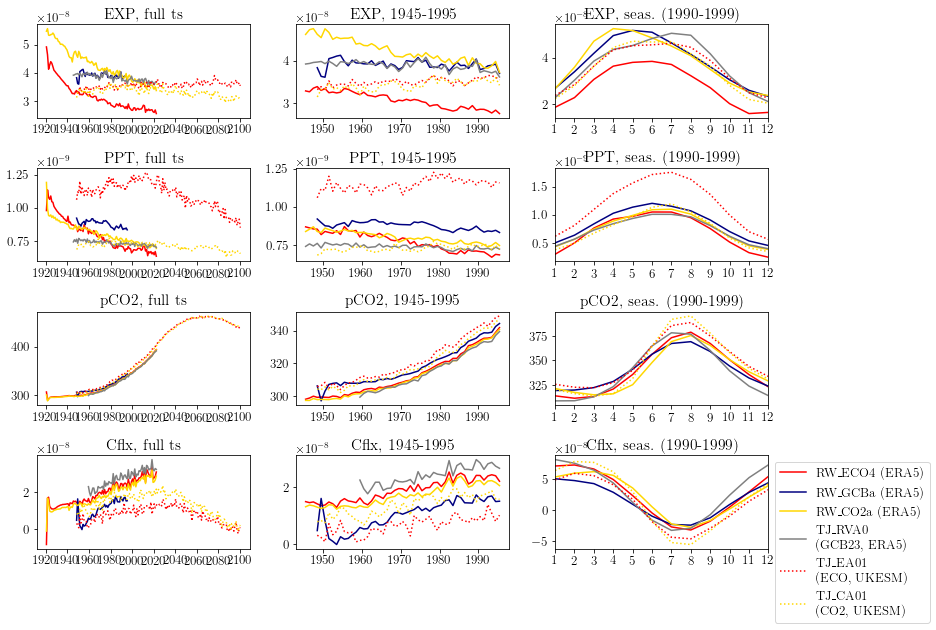

In [99]:
bd = '/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/'
fact = 1.1
fig, axs = plt.subplots(4,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvars = ['EXP','PPT','pCO2','Cflx']
ind = 0

for i in range(0,4):
    for m in ml:
        if m != 'TJ_GA01':
            t = glob.glob(f'{bd}/NAtl_{tvars[i]}_TOM12_{m}*')[0]
            w = xr.open_dataset(t)
            axs[0+ind].plot(w.time_counter.groupby('time_counter.year').mean(),\
                       w[tvars[i]].groupby('time_counter.year').mean(), color = ml[m]['color'],\
                       linestyle = ml[m]['linestyle'], label = ml[m]['desc'])
            axs[1+ind].plot(w.time_counter.sel(time_counter=slice(f'1945-01-01', f'1995-12-31')).\
                                           groupby('time_counter.year').mean(),\
                       w[tvars[i]].sel(time_counter=slice(f'1945-01-01', f'1995-12-31')).\
                                       groupby('time_counter.year').mean(), color = ml[m]['color'],\
                       label = ml[m]['desc'], linestyle = ml[m]['linestyle'])
            axs[2+ind].plot(np.arange(1,13,1),
                    w[tvars[i]].sel(time_counter=slice(f'1990-01-01', f'1999-12-31')).\
                                           groupby('time_counter.month').mean(), color = ml[m]['color'],\
                       label = ml[m]['desc'], linestyle = ml[m]['linestyle'])
            axs[2+ind].set_xticks(np.arange(1,13,1))
            axs[2+ind].set_xlim([1,12])

            axs[0+ind].set_title(f'{tvars[i]}, full ts')
            axs[1+ind].set_title(f'{tvars[i]}, 1945-1995')
            axs[2+ind].set_title(f'{tvars[i]}, seas. (1990-1999)')
    ind = ind+3
        
        
        
axs[11].legend(bbox_to_anchor = [1,1])

plt.tight_layout()

In [98]:
w

<xarray.Dataset>
Dimensions:       (time_counter: 1836)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1948-01-01 ... 2100-12-01
Data variables:
    Cflx          (time_counter) float64 ...
Attributes:
    made in:  /AMOC-PLANKTOM/available-model-ts.py
    desc: